In [118]:
%matplotlib inline

import os
import cv2
import numpy as np
import torch
import torchreid
from collections import Counter
from itertools import chain
from PIL import Image
from sklearn.cluster import DBSCAN, KMeans
from IPython.display import Video
from sklearn.preprocessing import StandardScaler
from scipy.misc import imread
from matplotlib import pyplot as plt
from torch.autograd import Variable
from torchvision.transforms import *
from scipy.spatial import distance_matrix

In [2]:
fast_path = os.path.join("newfaster", "faster-rcnn.pytorch")

os.chdir(fast_path)

from model.faster_rcnn.resnet import resnet
from model.utils.config import cfg
from model.roi_layers import nms
from model.utils.blob import im_list_to_blob
from model.rpn.bbox_transform import clip_boxes
from model.rpn.bbox_transform import bbox_transform_inv

os.chdir("../..")

In [3]:
cuda = True

In [4]:
def _get_image_blob(im):
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)

    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)

In [5]:
pascal_classes = np.asarray(['__background__',
                       'aeroplane', 'bicycle', 'bird', 'boat',
                       'bottle', 'bus', 'car', 'cat', 'chair',
                       'cow', 'diningtable', 'dog', 'horse',
                       'motorbike', 'person', 'pottedplant',
                       'sheep', 'sofa', 'train', 'tvmonitor'])

fasterRCNN = resnet(pascal_classes, 101, pretrained=False, class_agnostic=False)

In [6]:
fasterRCNN.create_architecture()
load_name = os.path.join(fast_path, "checkpoints", "res101", "pascal_voc", "faster_rcnn_1_1_10021.pth")

if cuda:
    checkpoint = torch.load(load_name)
else:
    checkpoint = torch.load(load_name, map_location=(lambda storage, loc: storage))
    
fasterRCNN.load_state_dict(checkpoint['model'])
if 'pooling_mode' in checkpoint.keys():
    cfg.POOLING_MODE = checkpoint['pooling_mode']

if cuda:
    fasterRCNN.cuda()

fasterRCNN.eval()

In [7]:
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)

if cuda:
    im_data = im_data.cuda()
    im_info = im_info.cuda()
    num_boxes = num_boxes.cuda()
    gt_boxes = gt_boxes.cuda()
    
with torch.no_grad():
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)

In [8]:
def get_boxes(im_in, thresh=0.99):
    if len(im_in.shape) == 2:
        im_in = im_in[:,:,np.newaxis]
        im_in = np.concatenate((im_in,im_in,im_in), axis=2)
    # rgb -> bgr
    im = im_in[:,:,::-1]

    blobs, im_scales = _get_image_blob(im)
    im_blob = blobs
    im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    with torch.no_grad():
        im_data.resize_(im_data_pt.size()).copy_(im_data_pt)
        im_info.resize_(im_info_pt.size()).copy_(im_info_pt)
        gt_boxes.resize_(1, 1, 5).zero_()
        num_boxes.resize_(1).zero_()

    rois, cls_prob, bbox_pred, \
    rpn_loss_cls, rpn_loss_box, \
    RCNN_loss_cls, RCNN_loss_bbox, \
    rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]

    # Apply bounding-box regression deltas
    box_deltas = bbox_pred.data
    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
    box_deltas = box_deltas.view(1, -1, 4 * len(pascal_classes))

    pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
    pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)

    pred_boxes /= im_scales[0]

    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()
    
    boxes = []
    for j in range(1, len(pascal_classes)):
        inds = torch.nonzero(scores[:,j]>0.98).view(-1)
        if inds.numel() > 0 and pascal_classes[j] == "person":
            cls_scores = scores[:,j][inds]
            _, order = torch.sort(cls_scores, 0, True)
            cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

            cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
            cls_dets = cls_dets[order]
            keep = nms(cls_boxes[order, :], cls_scores[order], cfg.TEST.NMS)
            cls_dets = cls_dets[keep.view(-1).long()]
            for i in range(np.minimum(6, cls_dets.shape[0])):
                bbox = tuple(int(np.round(x.cpu().numpy())) for x in cls_dets[i, :4])
                boxes.append(bbox)
    return boxes

In [9]:
# img_dir = "../../PRW-v16.04.20/frames/"
# images = []
# for imname in os.listdir(img_dir):
#     if imname.startswith("c1s1"):
#         images.append(imname)
# images.sort()
# len(images)

In [10]:
# video_name = '../../video.avi'

# frame = cv2.imread(os.path.join(img_dir, images[0]))
# height, width, layers = frame.shape

# # video = cv2.VideoWriter(video_name, 0, 1, (256,256))
# video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 20, (width,height))

# shapes = set()
# for image in images[:40]:
#     img = cv2.imread(os.path.join(img_dir, image))
#     boxes = get_boxes(img)
#     for bbox in boxes:
#         cv2.rectangle(img, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
#     video.write(img)
#     video.write(img)
#     video.write(img)

# cv2.destroyAllWindows()
# video.release()

In [11]:
reid_model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=702,
    use_gpu=True,
    pretrained=True
)

pretrained = "osnet_x1_0_duke_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth"
torchreid.utils.load_pretrained_weights(reid_model, pretrained)
reid_model = reid_model.cuda()
reid_model.eval()

height, width = 256, 128
norm_mean = [0.485, 0.456, 0.406] # imagenet mean
norm_std = [0.229, 0.224, 0.225] # imagenet std
normalize = Normalize(mean=norm_mean, std=norm_std)

transform_te = Compose([
        Resize((height, width)),
        ToTensor(),
        normalize,
    ])

Successfully loaded imagenet pretrained weights from "/home/oleg/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Successfully loaded pretrained weights from "osnet_x1_0_duke_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip.pth"


In [12]:
def get_embedding(img):
    img = Image.fromarray(img)
    batch = torch.unsqueeze(transform_te(img), 0).cuda()
    emb = reid_model(batch).cpu().detach().numpy()
#     emb /= np.linalg.norm(emb)
    return emb

In [13]:
cameras = os.listdir("videos")
cameras.sort()
cam_names = [cam.split('.')[0] for cam in cameras]
for cam in cam_names:
    if not os.path.exists(f"images/{cam}"):
        os.mkdir(f"images/{cam}")

In [14]:
# for cam in cameras:
#     cam_path = os.path.join("videos", cam)
#     cam_name = cam.split('.')[0]
#     vidcap = cv2.VideoCapture(cam_path)
#     print(f"FPS: {vidcap.get(cv2.CAP_PROP_FPS)}")
#     success, image = vidcap.read()
#     count = 0
#     while success:
#         cv2.imwrite(os.path.join("images", cam_name, f"frame{count}.jpg"), image)
#         success, image = vidcap.read()
#         count += 1
#     print(f"Camera {cam_name} has {count} frames!")

In [15]:
colors = np.array([(200, 0, 0), (0, 200, 0), (0, 0 , 200), (200, 200, 0), (0,0,0),(200,200,200), (0,200,200)])

In [16]:
def read_img(cam, i):
    return cv2.imread(f"images/{cam}/image-{str(i).rjust(7, '0')}.png")[:,:,::-1]

In [209]:
frame_i = 480
images = []
for cam in cam_names:
    images.append(read_img(cam, frame_i))
    
boxes_per_cam = []
embs_per_cam = []
for img in images:
    boxes = get_boxes(img)
    boxes_per_cam.append(boxes)

    embs = []
    for bbox in boxes:
        emb = get_embedding(img[bbox[1]:bbox[3],bbox[0]:bbox[2]])
        embs.append(emb)
        
    embs_per_cam.append(embs)

In [210]:
# embeddings = np.array(list(chain(*embs_per_cam))).squeeze()
# # embeddings = StandardScaler().fit_transform(embeddings)

# cluster_min_size, cluster_max_size = max(1,len(min(embs_per_cam, key=lambda x: len(x)))), len(embeddings)

# # db = min([KMeans(n_clusters=i).fit(embeddings) 
# #               for i in range(cluster_min_size, cluster_max_size)], 
# #              key=lambda db: abs(db.score(embeddings)))
# db = DBSCAN(eps=11, min_samples=2).fit(embeddings)

# colored_boxes = []
# total = 0
# for i, boxes in enumerate(boxes_per_cam):
#     colored_boxes.append(list(zip(boxes, db.labels_[total:total+len(boxes)])))
#     total += len(boxes)

In [211]:
def get_labels(embs_per_cam):
    not_pairs = []
    total = 0
    for cam in embs_per_cam:
        not_pairs.append(set(range(total, total + len(cam))))
        total += len(cam)

    embeddings = np.array(list(chain(*embs_per_cam))).squeeze()
#     print(embeddings.shape)
    if embeddings.shape[0] == 0:
        return []
    embeddings = embeddings.reshape((-1, 512))
    matrix = distance_matrix(embeddings, embeddings)

    def dist(i, j):
        return abs((sum(matrix[i]) - matrix[i, j]) / (len(embeddings) - 2) - matrix[i, j])

    classes = dict()
    num_classes = 0
    if all(len(cam) == 1 for cam in embs_per_cam) and matrix[0,1] < 9:
        classes[0] = 0
        classes[1] = 0
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            if (i != j 
                and i not in classes
                and j not in classes
                and not any(i in s and j in s for s in not_pairs)
                and 2. < dist(i,j)
                and dist(i,j) == max(dist(i,k) for k in range(len(embeddings)) if k != i)):
                classes[i] = num_classes
                classes[j] = num_classes
                num_classes += 1
                break
    for i in range(len(embeddings)):
        if i not in classes:
            classes[i] = num_classes
            num_classes += 1
            
    box_class = sorted(list(classes.items()), key=lambda p: p[0])
    labels = [p[1] for p in box_class]
    return labels

In [212]:
labels = get_labels(embs_per_cam)

colored_boxes = []
total = 0
for i, boxes in enumerate(boxes_per_cam):
    colored_boxes.append(list(zip(boxes, labels[total:total+len(boxes)])))
    total += len(boxes)

In [213]:
def show_img(img, colored_boxes, ax=plt):
    img = img[:,:,::-1]
    for bbox, ind in boxes:
        col = colors[ind]
        cv2.rectangle(img, bbox[0:2], bbox[2:4], (int(col[0]), int(col[1]), int(col[2])), 2)
    img = img[:,:,::-1]

    ax.imshow(img)
#     ax.show()

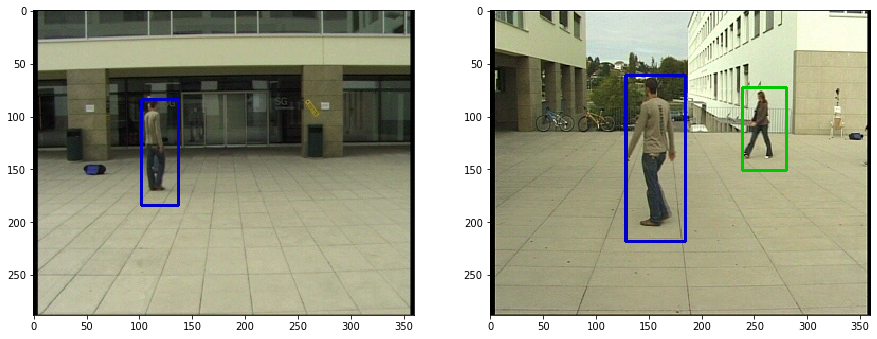

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))

for img, boxes, ax in zip(images, colored_boxes, axes):
    show_img(img, boxes, ax=ax)

In [28]:
# boxes_per_cam = []
# embs_per_cam = []

# for cam in cam_names:
#     boxes_per_cam.append([])
#     embs_per_cam.append([])
#     for frame_i in range(1,2000):
#         if frame_i % 100 == 0:
#             print(frame_i)
#         img = read_img(cam, frame_i)
#         boxes = get_boxes(img)
#         boxes_per_cam[-1].append(boxes)
#         embs = []
#         for bbox in boxes:
#             emb = get_embedding(img[bbox[1]:bbox[3],bbox[0]:bbox[2]])
#             embs.append(emb)
#         embs_per_cam[-1].append(embs)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [215]:
import pickle

with open("backup", "rb") as f:
    boxes_per_cam, embs_per_cam = pickle.load(f)

In [152]:
len(embs_per_cam[0])

1998

In [186]:
def flat_to_listed(flat, lists):
    flat_listed = []
    total = 0
    for l in lists:
        flat_listed.append(flat[total:total+len(l)])
        total += len(l)
    return flat_listed

In [255]:
classes = dict()
classes_per_cam = [[] for cam in cam_names]

for i in range(0,1998): # 1999
    frame_embs_per_cam = [embs[i] for embs in embs_per_cam]
#     print(frame_embs_per_cam)
    flat_embs = np.array(list(chain(*frame_embs_per_cam))).squeeze().reshape((-1,512))
    
#     print(np.array(list(chain(*flat_embs))).squeeze().shape)
    labels = np.array(get_labels(frame_embs_per_cam))
    
    cur_class_embs = []
    for j in range(len(set(labels))):
        embs = flat_embs[labels == j]
        emb = sum(embs) / len(embs)
        cur_class_embs.append(emb)
    cur_class_embs = np.array(cur_class_embs).squeeze().reshape((-1, 512))
    
    all_class_embs = []
    for j in classes:
        emb = sum(classes[j]) / len(classes[j])
        all_class_embs.append(emb)
    all_class_embs = np.array(all_class_embs).squeeze().reshape((-1, 512))
    
    listed_labels = flat_to_listed(labels, frame_embs_per_cam)
    
    new_to_old_classes = dict()
    
    if i == 0 or not classes:
        for lab in set(labels):
            new_to_old_classes[lab] = lab
            classes[lab] = []
    elif len(labels) > 0:
#         print(all_class_embs.shape, cur_class_embs.shape)
        matrix = distance_matrix(all_class_embs, cur_class_embs)
#         print(matrix)
#         print(labels)
        
        def dist(i, j):
            return abs((sum(matrix[i]) - matrix[i, j]) / (matrix.shape[1] - 1) - matrix[i, j])
        
        most_labs = [p[0] for p in Counter(labels).most_common()]
        
        flag = True
        
        while flag:
            flag = False
            for prev_lab in classes:
                if not flag and prev_lab not in new_to_old_classes.values():
                    for lab in most_labs:
#                         print(prev_lab, lab, dist(prev_lab, lab), max(dist(prev_lab,k) for k in most_labs if k != lab))
                        if (lab not in new_to_old_classes
                            and 2 < min([100] + [abs(matrix[prev_lab,j] - matrix[prev_lab, lab]) 
                                                 for j in most_labs if j not in new_to_old_classes and j != lab])
#                             and 3 < abs((sum(matrix[prev_lab]) - matrix[prev_lab, j]) / (matrix.shape[1] - 1) - matrix[prev_lab, j])
                            and matrix[prev_lab, lab] < 8.):
#                             and dist(prev_lab, lab) == max(dist(prev_lab,k) 
#                                                            for k in most_labs if k not in new_to_old_classes)):
                            new_to_old_classes[lab] = prev_lab
                            flag = True
                            break
#         print(new_to_old_classes)
        for lab in most_labs:
            if lab not in new_to_old_classes:
                new_to_old_classes[lab] = len(classes)
                classes[len(classes)] = []
                
    for li, lab in enumerate(labels):
        classes[new_to_old_classes[lab]].append(flat_embs[li])
     
    for i in range(len(cam_names)):
        classes_per_cam[i].append([new_to_old_classes[lab] for lab in listed_labels[i]])

/home/oleg/oleg_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [256]:
cnt = Counter(list(chain(*[[cls]*len(classes[cls]) for cls in classes])))
for p in cnt.most_common(10):
    print(p)
print(sum(p[1] for p in cnt.most_common()[5:]))

(0, 2354)
(2, 1686)
(3, 1352)
(4, 546)
(13, 227)
(6, 156)
(34, 75)
(28, 57)
(12, 55)
(9, 53)
662


In [261]:
# most_com = cnt.most_common()
# size = 1000:
# while
#     print(p)
conv = {0:0,2:1,3:2,4:3,13:4}


In [ ]:
(0, 2371)
(2, 1769)
(1, 1760)
(6, 205)
(9, 191)
(3, 142)
(8, 119)
(22, 63)
(10, 49)

In [262]:
for i, cam in enumerate(cam_names):
    video_name = f"{cam}_box.mp4"
    
    height, width, layers = 288, 360, 3

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 25, (width,height))
        
    for frame_i in range(1, 1999)[400:700]:
        img = read_img(cam, frame_i)
        boxes = boxes_per_cam[i][frame_i]

        embs = []
        for box_i, bbox in enumerate(boxes):
            img = img[:,:,::-1]
#             ind = np.argmin(np.linalg.norm(avg_per_class - emb, axis=1))
            ind = classes_per_cam[i][frame_i][box_i]
            if cnt[ind] > 200:
                col = colors[conv[ind]]
                cv2.rectangle(img, bbox[0:2], bbox[2:4], (int(col[0]), int(col[1]), int(col[2])), 2)
            img = img[:,:,::-1]
        img = img[:,:,::-1]
        video.write(img)
        if frame_i % 300 == 0:
            print(frame_i)

    cv2.destroyAllWindows()
    video.release()


600
600


In [ ]:
# cluster_min_size, cluster_max_size = max(1,len(min(embs_per_cam, key=lambda x: len(x)))), len(embeddings)

# db_min = min([KMeans(n_clusters=i).fit(embeddings) 
#               for i in range(cluster_min_size, cluster_max_size)], 
#              key=lambda db: abs(db.score(embeddings)))

In [23]:
embeddings = np.array(list(chain(*embs_per_cam))).squeeze()
print(distance_matrix(embeddings, embeddings))
# embeddings = StandardScaler().fit_transform(embeddings)
# print(distance_matrix(embeddings, embeddings))

[[ 0.       14.315571 13.112739  5.373642 13.84035  13.189161]
 [14.315571  0.       15.318637 14.775563 15.786358  8.268809]
 [13.112739 15.318637  0.       12.689002 14.957377 14.780937]
 [ 5.373642 14.775563 12.689002  0.       13.251825 13.255549]
 [13.84035  15.786358 14.957377 13.251825  0.       13.609933]
 [13.189161  8.268809 14.780937 13.255549 13.609933  0.      ]]


In [416]:
all_embs = []
for cam_num, cam in zip([1801, 1720], cam_names):
    for frame_i in range(0,cam_num):
        if frame_i % 100 == 0:
            print(frame_i)
        img = cv2.imread(f"images/{cam}/frame{frame_i}.jpg")[:,:,::-1]
        boxes = get_boxes(img)
        for bbox in boxes:
            emb = get_embedding(img[bbox[1]:bbox[3],bbox[0]:bbox[2]])
            all_embs.append(emb)
all_embs = np.array(all_embs)
all_embs.shape

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


(6500, 1, 512)

In [29]:
# for cam_num, cam in zip([1801, 1720], cam_names):
#     video_name = f"{cam}_box.mp4"
    
# #     frame = cv2.imread(os.path.join(img_dir, images[0]))
#     height, width, layers = 288, 360, 3

#     video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 25, (width,height))
        
#     for frame_i in range(cam_num):
#         img = cv2.imread(f"images/{cam}/frame{frame_i}.jpg")[:,:,::-1]
#         boxes = get_boxes(img)

#         embs = []
#         for bbox in boxes:
#             emb = get_embedding(img[bbox[1]:bbox[3],bbox[0]:bbox[2]])
#             img = img[:,:,::-1]
# #             norm = 
#             ind = np.argmin(np.linalg.norm(avg_per_class - emb, axis=1))
# #             print(ind)
#             col = colors[ind]
#             cv2.rectangle(img, bbox[0:2], bbox[2:4], (int(col[0]), int(col[1]), int(col[2])), 2)
#             img = img[:,:,::-1]
#         img = img[:,:,::-1]
#         video.write(img)
#         if frame_i % 300 == 0:
#             print(frame_i)

#     cv2.destroyAllWindows()
#     video.release()


0
300
600
900
1200
1500
1800
0
300
600
900
1200
1500


In [24]:
import pickle

# with open('backup.pickle', 'wb') as f:
#     pickle.dump(all_embs, f)
with open('backup.pickle', 'rb') as f:
    all_embs = pickle.load(f)

In [263]:
all_embs = np.array(list(chain(*list(chain(*embs_per_cam))))).reshape((-1, 512))

In [295]:
# db = DBSCAN(eps=6, min_samples=80).fit(all_embs)
db = KMeans(n_clusters=5).fit(all_embs)
print(set(db.labels_))

{0, 1, 2, 3, 4}


In [296]:
from collections import Counter

print(Counter(db.labels_).most_common())

[(0, 2275), (2, 1840), (3, 1070), (1, 1028), (4, 614)]


In [297]:
avg_per_class = []
for cls in set(db.labels_):
    if cls != -1:
        embs = all_embs[db.labels_ == cls]
        avg = sum(embs) / len(embs)
        avg_per_class.append(avg)
avg_per_class = np.array(avg_per_class)
avg_per_class.shape

(5, 512)

In [305]:
len(boxes_per_cam[0])

1998

In [307]:
classes_per_cam = []

for cami, cam in enumerate(cam_names):
    classes_per_cam.append([])
    video_name = f"{cam}_box.mp4"
    
    height, width, layers = 288, 360, 3

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), 25, (width,height))
        
    for frame_i in range(0, 1998):
        classes_per_frame = []
        img = read_img(cam, frame_i + 1)
        boxes = boxes_per_cam[cami][frame_i]

        embs = embs_per_cam[cami][frame_i]
        dists = []
        for emb in embs:
            dists.append(np.linalg.norm(avg_per_class - emb, axis=1))
        dists = np.array(dists)
        
        col_mins = [] if len(dists) == 0 else np.min(dists, axis=1)
        
        class_pairs = dict()
        for i in range(len(dists)):
            for j in range(len(col_mins)):
                if dists[i,j] == col_mins[j]:
                    
                    class_pairs[i] = [j] + class_pairs.get(i, [])
                    
        for i in class_pairs:
            class_pairs[i] = min(class_pairs[i], key=lambda j: dists[i,j])
            dists[:,class_pairs[i]] = 10000
            
        for i in range(len(dists)):
            if i not in class_pairs:
#                 class_pairs[i] = -1
                class_pairs[i] = np.argmin(dists[i])
                if dists[i][class_pairs[i]] == 10000:
                    class_pairs[i] = -1
                dists[:,class_pairs[i]] = 10000
                
        ind = np.argmin(np.linalg.norm(avg_per_class - emb, axis=1))
        for box_i, bbox in enumerate(boxes):
            img = img[:,:,::-1]
            ind = class_pairs[box_i]
            classes_per_frame.append(ind)
            if ind != -1:
                col = colors[ind]
                cv2.rectangle(img, bbox[0:2], bbox[2:4], (int(col[0]), int(col[1]), int(col[2])), 2)
            img = img[:,:,::-1]
        img = img[:,:,::-1]
        classes_per_cam[-1].append(classes_per_frame)
        video.write(img)
        if frame_i % 300 == 0:
            print(frame_i)

    cv2.destroyAllWindows()
    video.release()


0
300
600
900
1200
1500
1800
0
300
600
900
1200
1500
1800


In [47]:
cam_names

['campus4-c0', 'campus4-c1']

In [54]:
boxes_per_cam_per_10frames = []
for cam in cam_names:
    boxes_per_cam_per_10frames.append([])
    for frame_i in range(1,2000,10):
        if frame_i % 301 == 0:
            print(frame_i)
#         print(f"images/{cam}/image-{str(frame_i).rjust(7, '0')}.png")
        img = cv2.imread(f"images/{cam}/image-{str(frame_i).rjust(7, '0')}.png")[:,:,::-1]
        boxes = get_boxes(img)
        boxes_per_cam_per_10frames[-1].append(boxes)

In [420]:
len(boxes_per_cam_per_10frames[0][100])

4

In [308]:
import pickle

with open('classes_per_cam.pickle', 'wb') as f:
    pickle.dump(classes_per_cam, f)